In [ ]:
from pathlib import Path

import pandas as pd
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.iforest import IForest

RANDOM_STATE = 42
INPUT_PATH = Path("./src/data/output/clean_ura_data.csv")

CAT_IMPUTER_STRATEGY = "constant"
CAT_CONSTANT = "missing"
NUM_IMPUTER_STRATEGY = "mean"

AD_DROP = [
    "street",
    "project",
    "contract_date_dt",
    "days_since_1st_trans",
    "floorRange",
    "typeOfSale",
    "district",
    "typeOfArea",
    "marketSegment",
    "age_bin",
    "tenure_bin",
    "latitude",
    "longitude",
]
AD_CAT = ["marketSegment"]

DETECTORS = {
    "iforest": IForest(random_state=RANDOM_STATE),
    "auto_encoder": AutoEncoder(random_state=RANDOM_STATE),
}

df_ura = pd.read_csv(INPUT_PATH)

In [26]:
import logging

import pandas as pd

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


def diagnose_missing_data(df_ura, df_name="DataFrame"):
    missing_table = df_ura.isnull().sum().to_frame(name="missing_count")
    missing_table["missing_pct"] = (
        missing_table["missing_count"] / len(df_ura)
    ) * 100

    missing_table = missing_table[missing_table["missing_count"] > 0]

    if not missing_table.empty:
        logger.info("\nMissing values in %s:\n%s\n", df_name, missing_table)
    else:
        logger.info("\nNo missing values in %s.\n", df_name)

    return missing_table

In [23]:
import logging

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


def process_ad_data(
    df_ura,
    drop_features,
    cat_features,
    cat_imputer_strategy,
    num_imputer_strategy,
    cat_constant=None,
    num_constant=None,
):
    """
    Imputes missing values, encode categorical features, and scales numerical features.
    Also returns a boolean array indicating which columns are categorical.
    """

    ad_features = [col for col in df_ura.columns if col.startswith("ad_")]
    drop_cat_features = drop_features + cat_features + ad_features
    num_features = list(df_ura.columns.difference(drop_cat_features))
    df_copy = df_ura[num_features + cat_features].copy()

    cat_imputer = SimpleImputer(
        strategy=cat_imputer_strategy,
        fill_value=(
            cat_constant if cat_imputer_strategy == "constant" else None
        ),
    )
    num_imputer = SimpleImputer(
        strategy=num_imputer_strategy,
        fill_value=(
            num_constant if num_imputer_strategy == "constant" else None
        ),
    )

    cat_transformer = Pipeline(
        steps=[
            ("imputer", cat_imputer),
            ("encoder", OneHotEncoder(sparse_output=False)),
        ]
    )
    num_transformer = Pipeline(
        steps=[("imputer", num_imputer), ("scaler", StandardScaler())]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_transformer, num_features),
            ("cat", cat_transformer, cat_features),
        ]
    )

    pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

    logger.info(
        "Processing data for anomaly detection:\n"
        "Numerical features: %s\n"
        "Categorical features: %s\n",
        num_features,
        cat_features,
    )

    missing_table = diagnose_missing_data(df_copy, "anomaly detection data")
    if missing_table.empty:
        logger.info(
            "\nCategorical features will be one hot encoded.\n"
            "Numerical features will be standardized using the StandardScaler.\n"
        )
    else:
        logger.info(
            "\nCategorical features will be one hot encoded and imputed with %s. "
            "Numerical features will be standardized using the StandardScaler and imputed with %s.\n",
            cat_imputer_strategy,
            num_imputer_strategy,
        )

    x_processed = pipeline.fit_transform(df_copy)

    feature_names = pipeline.named_steps[
        "preprocessor"
    ].get_feature_names_out()
    is_cat = np.array(["cat__" in name for name in feature_names])

    return x_processed, is_cat

In [ ]:
# Adapted : M. Beckmann  https://github.com/scikit-learn/scikit-learn/pull/9555

import numpy as np
from scipy.sparse import issparse
from sklearn.metrics import pairwise
from sklearn.utils import validation


def check_pairwise_arrays(X, Y, precomputed=False, dtype=None):
    """Validate and format input arrays X and Y for pairwise operations."""
    X, Y, dtype_float = pairwise._return_float_dtype(X, Y)

    warn_on_dtype = dtype is not None
    estimator = "check_pairwise_arrays"

    if dtype is None:
        dtype = dtype_float

    if Y is X or Y is None:
        X = Y = validation.check_array(
            X,
            accept_sparse="csr",
            dtype=dtype,
            force_all_finite="allow-nan",
            estimator=estimator,
        )
    else:
        X = validation.check_array(
            X,
            accept_sparse="csr",
            dtype=dtype,
            force_all_finite="allow-nan",
            estimator=estimator,
        )
        Y = validation.check_array(
            Y,
            accept_sparse="csr",
            dtype=dtype,
            force_all_finite="allow-nan",
            estimator=estimator,
        )

    if precomputed:
        if X.shape[1] != Y.shape[0]:
            raise ValueError(
                "Precomputed metric requires shape "
                "(n_queries, n_indexed). Got (%d, %d) "
                "for %d indexed." % (X.shape[0], X.shape[1], Y.shape[0])
            )
    elif X.shape[1] != Y.shape[1]:
        raise ValueError(
            "Incompatible dimension for X and Y matrices: "
            "X.shape[1] == %d while Y.shape[1] == %d"
            % (X.shape[1], Y.shape[1])
        )

    return X, Y


def _gower_distance_row(
    xi_cat,
    xi_num,
    xj_cat,
    xj_num,
    feature_weight_cat,
    feature_weight_num,
    feature_weight_sum,
    cat_features,
    ranges_of_num,
    max_of_num,
):
    """
    Computes the Gower distance between one row and a set of rows for
    categorical and numerical features.
    """
    # categorical columns
    sij_cat = np.where(
        xi_cat == xj_cat, np.zeros_like(xi_cat), np.ones_like(xi_cat)
    )
    sum_cat = np.multiply(feature_weight_cat, sij_cat).sum(axis=1)

    # numerical columns
    abs_delta = np.absolute(xi_num - xj_num)
    sij_num = np.divide(
        abs_delta,
        ranges_of_num,
        out=np.zeros_like(abs_delta),
        where=ranges_of_num != 0,
    )

    sum_num = np.multiply(feature_weight_num, sij_num).sum(axis=1)
    sums = np.add(sum_cat, sum_num)
    sum_sij = np.divide(sums, feature_weight_sum)
    return sum_sij


def gower_distances(X, Y=None, feature_weight=None, cat_features=None):
    """
    Computes the Gower distances between X and Y.

    Gower is a similarity measure for categorical, boolean, and numerical mixed data.

    :param X: First dataset of shape (n_samples, n_features)
    :type X: array-like or pandas.DataFrame
    :param Y: Second dataset of shape (n_samples, n_features)
    :type Y: array-like or pandas.DataFrame
    :param feature_weight: Attribute weights according to the Gower formula
    :type feature_weight: array-like of shape (n_features)
    :param categorical_features: Indicates whether each column is categorical (True/False) or
                                 list of indices for categorical columns. Ordinal attributes
                                 should be marked as False.
    :type categorical_features: array-like of shape (n_features) or list of int
    :return: Similarity matrix
    :rtype: numpy.ndarray of shape (n_samples, n_samples)

    :note: The non-numeric features and numeric feature ranges are determined from X and not Y.
           Sparse matrices are not supported.
    """

    if issparse(X) or issparse(Y):
        raise TypeError("Sparse matrices are not supported for gower distance")

    y_none = Y is None

    # It is necessary to convert to ndarray in advance to define the dtype
    if not isinstance(X, np.ndarray):
        X = np.asarray(X)

    # this is necessary as strangelly the validator is rejecting
    # numeric arrays with NaN
    array_type = object

    if np.issubdtype(X.dtype, np.number) and (
        np.isfinite(X.sum()) or np.isfinite(X).all()
    ):
        array_type = type(np.zeros(1, X.dtype).flat[0])

    X, Y = check_pairwise_arrays(X, Y, precomputed=False, dtype=array_type)

    n_rows, n_cols = X.shape

    if cat_features is None:
        cat_features = np.zeros(n_cols, dtype=bool)
        for col in range(n_cols):
            # In numerical columns, None is converted to NaN,
            # and the type of NaN is recognized as a number subtype
            if not np.issubdtype(type(X[0, col]), np.number):
                cat_features[col] = True
    else:
        cat_features = np.array(cat_features)

    if np.issubdtype(cat_features.dtype, np.int64):
        new_cat_features = np.zeros(n_cols, dtype=bool)
        new_cat_features[cat_features] = True
        cat_features = new_cat_features

    # Categorical columns
    X_cat = X[:, cat_features]

    # Numerical columns
    X_num = X[:, np.logical_not(cat_features)].astype(np.float32)
    ranges_of_num = None
    max_of_num = None

    # Calculates the normalized ranges and max values of numeric values
    _, num_cols = X_num.shape
    ranges_of_num = np.zeros(num_cols)
    max_of_num = np.zeros(num_cols)
    for col in range(num_cols):
        col_array = X_num[:, col].astype(np.float32)
        max = np.nanmax(col_array)
        min = np.nanmin(col_array)

        if np.isnan(max):
            max = 0.0
        if np.isnan(min):
            min = 0.0
        max_of_num[col] = max
        ranges_of_num[col] = np.absolute(1 - min / max) if (max != 0) else 0.0

    # This is to normalize the numeric values between 0 and 1.
    X_num = np.divide(
        X_num, max_of_num, out=np.zeros_like(X_num), where=max_of_num != 0
    )

    if feature_weight is None:
        feature_weight = np.ones(n_cols)

    feature_weight_cat = feature_weight[cat_features]
    feature_weight_num = feature_weight[np.logical_not(cat_features)]

    y_n_rows, _ = Y.shape

    dm = np.zeros((n_rows, y_n_rows), dtype=np.float32)

    feature_weight_sum = feature_weight.sum()

    Y_cat = None
    Y_num = None

    if not y_none:
        Y_cat = Y[:, cat_features]
        Y_num = Y[:, np.logical_not(cat_features)].astype(np.float32)
        # This is to normalize the numeric values between 0 and 1.
        Y_num = np.divide(
            Y_num, max_of_num, out=np.zeros_like(Y_num), where=max_of_num != 0
        )
    else:
        Y_cat = X_cat
        Y_num = X_num

    for i in range(n_rows):
        j_start = i

        # for non square results
        if n_rows != y_n_rows:
            j_start = 0

        Y_cat[j_start:n_rows, :]
        Y_num[j_start:n_rows, :]
        result = _gower_distance_row(
            X_cat[i, :],
            X_num[i, :],
            Y_cat[j_start:n_rows, :],
            Y_num[j_start:n_rows, :],
            feature_weight_cat,
            feature_weight_num,
            feature_weight_sum,
            cat_features,
            ranges_of_num,
            max_of_num,
        )
        dm[i, j_start:] = result
        dm[i:, j_start] = result

    return dm

In [ ]:
import numpy as np
import pandas as pd
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.iforest import IForest


def detect_anomaly(df_ura, detectors):
    df_copy = df_ura.copy()
    n_detectors = len(detectors)

    logger.info("Running Anomaly Detection:\n")
    x_processed, _ = process_ad_data(
        df_ura,
        drop_features=AD_DROP,
        cat_features=AD_CAT,
        cat_imputer_strategy=CAT_IMPUTER_STRATEGY,
        num_imputer_strategy=NUM_IMPUTER_STRATEGY,
        cat_constant=CAT_CONSTANT,
    )

    outlier_scores = np.zeros([x_processed.shape[0], n_detectors])
    labels = np.zeros([x_processed.shape[0], n_detectors])

    for i, (_, detector) in enumerate(detectors.items()):

        logger.info(f"Running Detector {i}.\n{detector}\n")
        detector.fit(x_processed)
        outlier_scores[:, i] = detector.decision_scores_
        labels[:, i] = detector.labels_

    score_cols = [f"ad_{detector_name}" for detector_name in detectors.keys()]
    label_cols = [f"ad_{detector_name}_label" for detector_name in detectors.keys()]
    
    outlier_scores_df = pd.DataFrame(
        np.round(outlier_scores, 3),
        columns=[f"ad_{detector_name}" for detector_name in detectors.keys()],
    )

    labels_df = pd.DataFrame(
        labels.astype(int),
        columns=[f"ad_{name}_label" for name in detectors.keys()],
    )

    df_copy = df_copy.join(outlier_scores_df)
    df_copy = df_copy.join(labels_df)


    
#     df_ad_sample = sample_ad_data(
#     df_copy,
#     score_col="ad_iforest",
#     label_col="ad_iforest_label",
#     top_n_outliers=10,
#     total_sample_size=150,
# )
    for i, (_, detector) in enumerate(detectors.items()):
        

    return df_copy


df_ad_results = detect_anomaly(df_ura, detectors=DETECTORS)

INFO:__main__:Running Anomaly Detection:

INFO:__main__:Processing data for anomaly detection:
Numerical features: ['area', 'noOfUnits', 'target_price']
Categorical features: ['marketSegment']

INFO:__main__:
No missing values in anomaly detection data.

INFO:__main__:
Categorical features will be one hot encoded.
Numerical features will be standardized using the StandardScaler.

INFO:__main__:Running Detector 0.
IForest(behaviour='old', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1, random_state=42,
    verbose=0)

INFO:__main__:Running Detector 1.
AutoEncoder(batch_norm=True, batch_size=32, compile_mode='default',
      contamination=0.1, device=device(type='cpu'), dropout_rate=0.2,
      epoch_num=10, hidden_activation_name='relu',
      hidden_neuron_list=[64, 32], lr=0.001, optimizer_name='adam',
      optimizer_params={'weight_decay': 1e-05}, preprocessing=True,
      random_state=42, use_compile=False, verbose=1)

Traini

In [ ]:
def sample_ad_data(
    df_ad,
    score_cols,
    label_cols,
    top_n_outliers=100,
    total_sample_size=500,
    random_state=RANDOM_STATE,
):

    df_ad_samples = {}

    for score_col, label_col in zip(score_cols, label_cols):
        df_outliers = (
            df_ad[df_ad[label_col] == 1]
            .sort_values(by=score_col, ascending=False)
            .head(top_n_outliers)
        )

        n_inliers = total_sample_size - top_n_outliers
        df_inliers = df_ad[df_ad[label_col] == 0].sample(
            n=n_inliers, random_state=random_state
        )
        df_ad_samples[score_col] = pd.concat(
            [df_outliers, df_inliers]
        ).reset_index(drop=True)

    return df_ad_samples


df_ad_samples = sample_ad_data(
    df_ad_results,
    score_cols=["ad_iforest"],
    label_cols=["ad_iforest_label"],
    top_n_outliers=10,
    total_sample_size=150,
)
print(df_ad_samples.keys())

dict_keys(['ad_iforest'])


INFO:__main__:Plotting 2D UMAP with label column: ad_iforest_label

INFO:__main__:Processing data for anomaly detection:
Numerical features: ['area', 'noOfUnits', 'target_price']
Categorical features: ['marketSegment']

INFO:__main__:
No missing values in anomaly detection data.

INFO:__main__:
Categorical features will be one hot encoded.
Numerical features will be standardized using the StandardScaler.

INFO:__main__:
Computing gower distance matrix for UMAP.


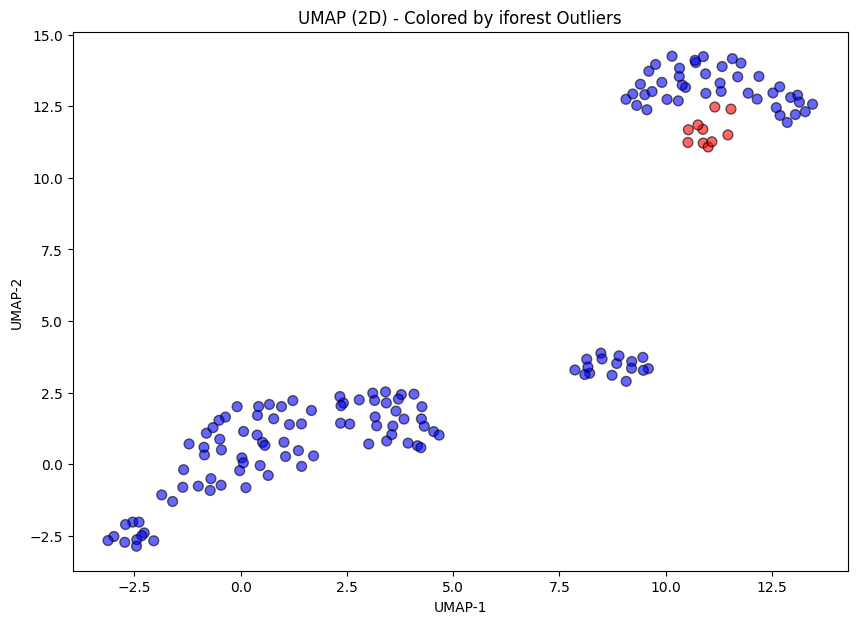

In [ ]:
import warnings
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


def plot_ad_umap(df_ad, label_col, gower=False):
    warnings.filterwarnings("ignore")
    logger.info("Plotting 2D UMAP with label column: %s\n", label_col)

    x_processed, is_cat = process_ad_data(
        df_ad,
        drop_features=AD_DROP,
        cat_features=AD_CAT,
        cat_imputer_strategy=CAT_IMPUTER_STRATEGY,
        num_imputer_strategy=NUM_IMPUTER_STRATEGY,
        cat_constant=CAT_CONSTANT,
    )

    if gower:
        logger.info("\nComputing gower distance matrix for UMAP.")
        x_processed = gower_distances(x_processed, cat_features=is_cat)
        metric = "precomputed"
    else:
        metric = "euclidean"

    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=50,
        min_dist=0.5,
        metric=metric,
        random_state=RANDOM_STATE,
    )
    embedding = reducer.fit_transform(x_processed)

    colors = ["blue" if label == 0 else "red" for label in df_ad[label_col]]

    plt.figure(figsize=(10, 7))
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=colors,
        alpha=0.6,
        s=50,
        edgecolor="k",
    )

    title_part = (
        label_col.split("_")[1] if len(label_col.split("_")) > 2 else label_col
    )
    plt.title(f"UMAP (2D) - Colored by {title_part} Outliers")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.show()


plot_ad_umap(df_ad_sample, label_col="ad_iforest_label", gower=True)

In [ ]:
display(df_ad_results.sort_values(by="ad_iforest", ascending=False).head(20))
print(df_ad_results["ad_iforest_label"].sum() / len(df_ad_results))

display(
    df_ad_results.sort_values(by="ad_auto_encoder", ascending=False).head(10)
)
print(df_ad_results["ad_auto_encoder_label"].sum() / len(df_ad_results))

,target_price,area,floorRange,noOfUnits,typeOfSale,district,typeOfArea,street,project,marketSegment,contract_date_dt,days_since_1st_trans,age_bin,tenure_bin,latitude,longitude,ad_iforest,ad_auto_encoder,ad_iforest_label,ad_auto_encoder_label
47299,392180000,13460.0,Floor 16-20,60,3,15,Strata,MEYER ROAD,MEYER PARK,RCR,2023-02-01,1006,Freehold,Freehold,1.296257,103.891646,0.254,24.952,1,1
42958,371000000,14123.0,Floor 01-05,72,3,5,Strata,YEW SIANG ROAD,FLYNN PARK,RCR,2021-09-01,488,Freehold,Freehold,1.278915,103.792744,0.254,23.576,1,1
43625,152000000,6084.0,Floor 11-15,40,3,15,Strata,TANJONG RHU ROAD,LA VILLE,RCR,2021-11-01,549,Freehold,Freehold,1.299737,103.884418,0.251,14.333,1,1
21062,12200000,635.0,Floor 06-10,1,3,4,Strata,KEPPEL BAY VIEW,REFLECTIONS AT KEPPEL BAY,RCR,2022-08-01,822,"(0.803, 20.7]",99 yrs,1.267145,103.811002,0.248,1.918,1,1
22205,12500000,699.0,Floor 21-25,1,3,4,Strata,KEPPEL BAY VIEW,REFLECTIONS AT KEPPEL BAY,RCR,2022-10-01,883,"(0.803, 20.7]",99 yrs,1.267145,103.811002,0.248,2.073,1,1
18582,19000000,769.0,Floor 21-25,1,3,4,Strata,KEPPEL BAY VIEW,REFLECTIONS AT KEPPEL BAY,RCR,2022-05-01,730,"(0.803, 20.7]",99 yrs,1.267145,103.811002,0.248,2.814,1,1
21145,17625000,655.0,Floor 36-40,1,3,4,Strata,KEPPEL BAY VIEW,REFLECTIONS AT KEPPEL BAY,RCR,2022-09-01,853,"(0.803, 20.7]",99 yrs,1.267145,103.811002,0.248,2.521,1,1
24475,17000000,635.0,Floor 06-10,1,3,4,Strata,KEPPEL BAY VIEW,REFLECTIONS AT KEPPEL BAY,RCR,2023-03-01,1034,"(0.803, 20.7]",99 yrs,1.267145,103.811002,0.248,2.423,1,1
43195,14200000,528.0,Floor 01-05,1,1,15,Strata,MEYER ROAD,MEYERHOUSE,RCR,2021-10-01,518,Freehold,Freehold,1.298244,103.893432,0.247,1.967,1,1
40640,13873860,526.0,Floor 01-05,1,1,15,Strata,MEYER ROAD,MEYERHOUSE,RCR,2021-03-01,304,Freehold,Freehold,1.298244,103.893432,0.246,1.923,1,1


0.09998837569745815


,target_price,area,floorRange,noOfUnits,typeOfSale,district,typeOfArea,street,project,marketSegment,contract_date_dt,days_since_1st_trans,age_bin,tenure_bin,latitude,longitude,ad_iforest,ad_auto_encoder,ad_iforest_label,ad_auto_encoder_label
20105,890000000,57584.0,Floor 21-25,446,3,19,Strata,LORONG CHUAN,CHUAN PARK (DEMOLISHED),OCR,2022-07-01,791,"(40.4, 60.1]",99 yrs,1.352324,103.865323,0.224,127.062,1,1
43145,550800000,19296.0,Floor 01-05,104,3,11,Strata,SHELFORD ROAD,WATTEN ESTATE CONDOMINIUM,CCR,2021-10-01,518,Freehold,Freehold,1.329234,103.810629,0.238,32.640,1,1
47299,392180000,13460.0,Floor 16-20,60,3,15,Strata,MEYER ROAD,MEYER PARK,RCR,2023-02-01,1006,Freehold,Freehold,1.296257,103.891646,0.254,24.952,1,1
42958,371000000,14123.0,Floor 01-05,72,3,5,Strata,YEW SIANG ROAD,FLYNN PARK,RCR,2021-09-01,488,Freehold,Freehold,1.278915,103.792744,0.254,23.576,1,1
43625,152000000,6084.0,Floor 11-15,40,3,15,Strata,TANJONG RHU ROAD,LA VILLE,RCR,2021-11-01,549,Freehold,Freehold,1.299737,103.884418,0.251,14.333,1,1
47104,115280000,6363.0,Floor -,43,3,16,Strata,UPPER EAST COAST ROAD,BAGNALL COURT,OCR,2023-01-01,975,Freehold,Freehold,1.320102,103.954923,0.222,12.053,1,1
43197,75000000,1122.0,Floor 01-05,1,1,10,Strata,NASSIM ROAD,LES MAISONS NASSIM,CCR,2021-10-01,518,Freehold,Freehold,1.308690,103.823942,0.233,8.216,1,1
46512,68000000,1043.0,Floor 01-05,1,1,10,Strata,NASSIM ROAD,LES MAISONS NASSIM,CCR,2022-10-01,883,Freehold,Freehold,1.308690,103.823942,0.233,7.479,1,1
44556,59768640,1121.0,Floor 01-05,1,1,10,Strata,NASSIM ROAD,LES MAISONS NASSIM,CCR,2022-03-01,669,Freehold,Freehold,1.308690,103.823942,0.233,6.448,1,1
46260,46000000,807.0,Floor 01-05,1,1,10,Strata,NASSIM ROAD,LES MAISONS NASSIM,CCR,2022-09-01,853,Freehold,Freehold,1.308690,103.823942,0.233,4.963,1,1


0.1000077495350279


C:\Users\halfb\miniconda3\envs\milestone2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\halfb\miniconda3\envs\milestone2\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


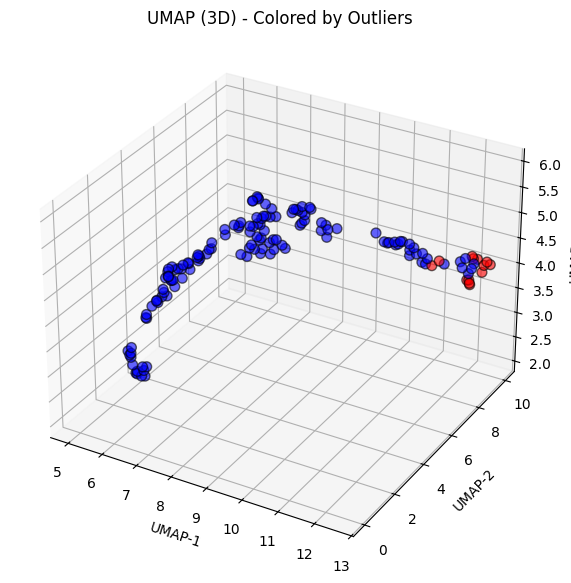

In [ ]:
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler

X = df_sampled[AD_NUM].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

reducer = umap.UMAP(n_components=3, random_state=RANDOM_STATE)
embedding = reducer.fit_transform(X_scaled)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

# Color points by IForest_label
colors = [
    "blue" if label == 0 else "red"
    for label in df_sampled["Auto Encoder_label"]
]

ax.scatter(
    embedding[:, 0],
    embedding[:, 1],
    embedding[:, 2],
    c=colors,
    alpha=0.6,
    s=50,
    edgecolor="k",
)

ax.set_title("UMAP (3D) - Colored by Outliers")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.set_zlabel("UMAP-3")
plt.show()

In [78]:
df_results.to_csv("./test.csv", index=False)

In [ ]:
import umap.plot

mapper = umap.UMAP().fit(df_sampled[AD_NUM])
umap.plot.points(mapper)

In [ ]:
from sklearn.model_selection import train_test_split

sample_size = 500
frac = sample_size / len(df_results)

df_sampled, _ = train_test_split(
    df_results,
    train_size=frac,
    stratify=df_results["Auto Encoder_label"],
    random_state=RANDOM_STATE,
)

print(df_sampled["Auto Encoder_label"].value_counts(normalize=True))
print(len(df_sampled))  # should be close to 5000

Auto Encoder_label
0    0.9
1    0.1
Name: proportion, dtype: float64
500


In [ ]:
len(
    df_ad_results[
        df_ad_results["ad_iforest_label"]
        != df_ad_results["ad_auto_encoder_label"]
    ]
)

3043